In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import xarray as xr
from netCDF4 import Dataset # Because we will change the netCDF files on disk in some cases
import numpy as np                
import os, subprocess, glob
from shutil import copy2
import urllib
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams[ 'ps.fonttype'] = 42

#
# Remove files from previous executions of this notebook
#
for f in glob.glob(os.path.join("data", "rrtmgp*.nc")): os.remove(f)

# User directory configuration 

In [2]:
# Location of RTE+RRTMGP distribution directory
#
# Note - this notebook will build the RTE and RRTMGP libraries if they haven't been built before, 
#   along with the RFMIP example, so will require users to create
#   a Makefile.conf file in the rte_rrtmgp_dir/build that specifes FC and FCFLAGS, and 
#   a Makefile.libs file in rte_rrtmgp_dir/examples/rfmip-clear-sky that specifies NCHOME and NFHOME 
#
rte_rrtmgp_dir  = os.path.join(os.path.expanduser("~"), "Codes/rte-rrtmgp/")
if not os.path.isfile(os.path.join(rte_rrtmgp_dir, "build", "Makefile.conf")): raise Exception("Makefile.conf has to exist in RTE build directory")
if not os.path.isfile(os.path.join(rte_rrtmgp_dir, "examples/rfmip-clear-sky", "Makefile.libs")): raise Exception("Makefile.libs has to exist in RFMIP examples directory")

# Notebook setup: modules and functions

In [3]:
fig_size = 95 
p_tropo = 10000  # Tropopause is 100 hPa

def copyVar(nc_in, nc_out, name) :
    nc_out.createVariable(name, nc_in.variables[name].dtype, nc_in.variables[name].dimensions)
    nc_out.variables[name].setncatts(nc_in.variables[name].__dict__)
    nc_out.variables[name][:] = nc_in.variables[name][:]
    return None
# 
# A function to create a "three-angle" file, i.e. one with the same input data but an "angle" dimension of extent 3
#   so the Garand atmospheres LW code will use three-angles in the non-scattering solution 
#

def make_three_angle_file(ref_file, new_file):
    varsToDel = ['angle', 'angle_secant', 'angle_weight']
    dimsToDel = ['angle']
    f    = Dataset(new_file, 'w')
    oldF = Dataset(ref_file)  
    for d in oldF.dimensions: 
        if not d in dimsToDel: f.createDimension(oldF.dimensions[d].name, oldF.dimensions[d].size)
    for v in oldF.variables:  
        if not v in varsToDel: copyVar(oldF, f, v)
    oldF.close()
    f.createDimension("angle", 3)
    f.close()
    return None
    
# https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')   

def level_index(location, data, pressure = "p_lev"): 
    #
    # Find the integer value of lev that corresponds to desired pressure = (max(p) for 'sfc', closest value to 100 hPa for 'tropo', min(p) for 'toa')
    #   For the Garand files we assume that pressures are the same for all columns
    #
    # argument location is text; data is xarray dataset 
    #
    sfc = data.isel(col=0).variables[pressure].argmax()
    toa = data.isel(col=0).variables[pressure].argmin()
    tropo = np.abs(data.isel(col=0).variables[pressure][:] - p_tropo).argmin()
    locs = {'sf':sfc, 'su':sfc, 'to':toa, 'tr':tropo}
    return(locs.get(location[:2].lower(), -1))
    
def compute_error_range(location, quantity, ref_file, test_files):
    # location and quantity are text strings 
    ref_ds = xr.open_dataset(ref_file)
    tst_ds = [xr.open_dataset(f) for f in test_files]

    i = level_index(location,ref_file)
    ref = ref_ds.isel(lev=i).variables[quantity]
    errs = [tf.isel(lev=i).variables[quantity] - ref for tf in tst_ds]
    ref_ds.close()
    [tf.close() for tf in tst_ds]
    return(errs.minval(), errs.maxval())

def plot_err_distribution(axes, errs, test_labels, ylabel = "Error", colors = None):
    if colors == None: 
        sb.boxplot(data = errs)
    else:
        default = sb.color_palette(palette = None)
        sb.boxplot(data = errs, palette = sb.color_palette([default[c] for c in colors]))
        
    sb.swarmplot(data = errs, color = "0.25")
    axes.set_ylabel(ylabel)
    axes.set_xticklabels(test_labels)
    axes.axhline()

# Data from external calculations

In [4]:
#
# Results from LBLRTM and RRTMG 
#
lw_lblrtm_file = 'data/lblrtm-lw-inputs-outputs-all.nc'
lw_rrtmg_file  = 'data/' + 'rrtmg-lw-inputs-outputs_alb_0.2_sza_30.nc'
sw_charts_file = 'data/charts-sw-inputs-outputs-clear_alb0_sza30.nc'
sw_rrtmg_file  = 'data/' + 'rrtmg-sw-inputs-outputs_alb_0.0_sza_30.nc'
#
# Location of surface, top-of-atmosphere
#
lw_lblrtm = xr.open_dataset(lw_lblrtm_file)
toa = (lw_lblrtm.variables['p_lev'][:]).argmin(dim="lev")
sfc = (lw_lblrtm.variables['p_lev'][:]).argmax(dim="lev")
lw_lblrtm.close()
#
# heating rates in RRTMG files are in K/d; modify to K/s
# net flux is negative in SW file
#
copy2(lw_rrtmg_file, "data/" + "rrtmg-lw-inputs-outputs.nc")
lw_rrtmg_file = "data/" + "rrtmg-lw-inputs-outputs.nc"
copy2(sw_rrtmg_file, "data/" + "rrtmg-sw-inputs-outputs.nc")
sw_rrtmg_file = "data/" + "rrtmg-sw-inputs-outputs.nc"
for f in [sw_rrtmg_file, lw_rrtmg_file]: 
    x = Dataset(f, 'a')
    x.variables["heating_rate"][:] = x.variables["heating_rate"][:]/86400.
    x.close()
for f in [sw_rrtmg_file]: 
    x = Dataset(f, 'a')
    x.variables["flux_net"][:] = -x.variables["flux_net"][:]
    x.close()


# RRTMGP calculations

In [5]:
#
# Set up the ability to calculate fluxes with RRTMGP
#   Build the RTE+RRMTGP library
#   This relies on users have set up a Makefile.conf in rte_rrtmgp_dir + "build/" or 
#   having defined variables FC and FCFLAGS in the environment 
#
subprocess.run(["export RRTMGP_ROOT=" + rte_rrtmgp_dir + "; " + \
                "cd " + rte_rrtmgp_dir + "build/; make "], shell=True)
#
# Build the program that computes fluxes from netCDF Garand atmosphere files
#   Users will need to have created a Makefile.libs in the RTE+RRTMGP directory 
#   that points to the netCDF C and Fortran installations 
# 
 
subprocess.run(["export RRTMGP_ROOT=" + rte_rrtmgp_dir + "; make "], shell=True)
flux_exe_name   = "rrtmgp_garand_atmos"

#
# Coefficient files, executable for Garand atmospheres
#
copy2(rte_rrtmgp_dir + "rrtmgp/data/rrtmgp-data-lw-g256-2018-12-04.nc", "data/coefficients_lw.nc")
copy2(rte_rrtmgp_dir + "rrtmgp/data/rrtmgp-data-sw-g224-2018-12-04.nc", "data/coefficients_sw.nc")

'data/coefficients_sw.nc'

In [6]:
#
# RRTMGP calculations 
#

#
# Compute RRTMGP LW and SW solution
#
sw_rrtmgp_default_file = "data/" + "rrtmgp-sw-inputs-outputs-default.nc"
sw_rrtmgp_untuned_file = "data/" + "rrtmgp-sw-inputs-outputs-untuned.nc"
lw_rrtmgp_default_file = "data/" + "rrtmgp-lw-inputs-outputs-default.nc"
lw_rrtmgp_untuned_file = "data/" + "rrtmgp-lw-inputs-outputs-untuned.nc"

copy2(sw_charts_file, sw_rrtmgp_default_file)
copy2(sw_charts_file, sw_rrtmgp_untuned_file)
copy2(lw_lblrtm_file, lw_rrtmgp_default_file)
copy2(lw_lblrtm_file, lw_rrtmgp_untuned_file)

# Compute three-angle solutions - use the LBLRTM setup but remove the 
#   angle dimension and any variables that use it, then create a new
#   angle dimension of length 3 (this is how the RRTMGP driver knows 
#   how many quadrature angles to use)
#

lw_rrtmgp_3ang_default_file = "data/" + "rrtmgp-lw-inputs-outputs-3angle-default.nc"
lw_rrtmgp_3ang_untuned_file = "data/" + "rrtmgp-lw-inputs-outputs-3angle-untuned.nc"
for fn in [lw_rrtmgp_3ang_default_file, lw_rrtmgp_3ang_untuned_file]: make_three_angle_file(lw_lblrtm_file, fn)

subprocess.run(["./" + flux_exe_name, sw_rrtmgp_default_file,      "data/coefficients_sw.nc"])
subprocess.run(["./" + flux_exe_name, sw_rrtmgp_untuned_file,      "data/coefficients_sw_noscaling.nc"])
subprocess.run(["./" + flux_exe_name, lw_rrtmgp_3ang_default_file, "data/coefficients_lw.nc"])
subprocess.run(["./" + flux_exe_name, lw_rrtmgp_3ang_untuned_file, "data/coefficients_lw_noscaling.nc"])
subprocess.run(["./" + flux_exe_name, lw_rrtmgp_default_file,      "data/coefficients_lw.nc"])
subprocess.run(["./" + flux_exe_name, lw_rrtmgp_untuned_file,      "data/coefficients_lw_noscaling.nc"])

CompletedProcess(args=['./rrtmgp_garand_atmos', 'data/rrtmgp-lw-inputs-outputs-untuned.nc', 'data/coefficients_lw_noscaling.nc'], returncode=0)

# Assessing the k-distribution (tuned and un-tuned)

In [7]:
def plot_single_level_errs(fig, axes, location, quantity, ref_file, test_files, test_labels, colors = None):
    """Plot the difference in 'quantity' at 'location' between a reference and one or more tests"""
    ref_ds = xr.open_dataset(ref_file)
    tst_ds = [xr.open_dataset(f) for f in test_files]

    i = level_index(location, ref_ds)
    ref = ref_ds.isel(lev=i).variables[quantity]
    errs = [tf.isel(lev=i).variables[quantity] - ref for tf in tst_ds]
    ref_ds.close()
    [tf.close() for tf in tst_ds]
    
    plot_err_distribution(axes, errs, test_labels, ylabel = "Error $\mathregular{(W/m^2)}$", colors = colors)

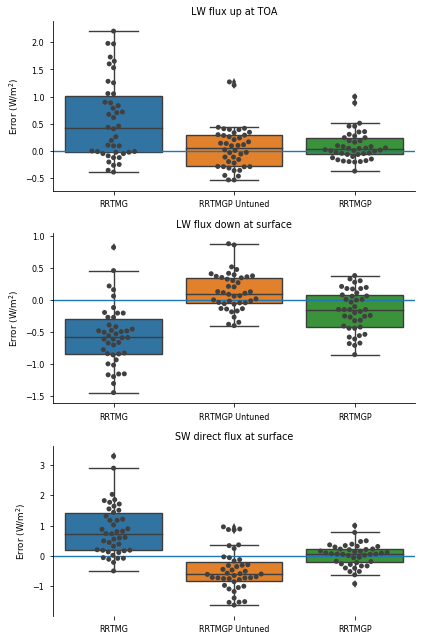

In [8]:
#
# Assessing the k-distribution: 
#  LW: three-angle solutions at TOA and SFC
#  use RRMTG too because tuned diffusivity angle 
#
sb.set_context("paper")
fig = plt.figure(figsize=(6,9))
axes = fig.add_subplot(311)
plot_single_level_errs(fig, axes, "toa", "flux_up", lw_lblrtm_file, \
                      [lw_rrtmg_file, lw_rrtmgp_3ang_untuned_file, lw_rrtmgp_3ang_default_file], \
                      ["RRTMG", "RRTMGP Untuned", "RRTMGP"])
sb.despine()
axes.spines["bottom"].set_visible(False)
axes.title.set_text("LW flux up at TOA")

axes = fig.add_subplot(312)
plot_single_level_errs(fig, axes, "sfc", "flux_dn", lw_lblrtm_file, \
                      [lw_rrtmg_file, lw_rrtmgp_3ang_untuned_file, lw_rrtmgp_3ang_default_file], \
                      ["RRTMG", "RRTMGP Untuned", "RRTMGP"])
axes.title.set_text("LW flux down at surface")
sb.despine()
axes.spines["bottom"].set_visible(False)
plt.savefig("lw-sfc-kdist-tuning.pdf", dpi=600)


#
#  SW: direct beam at SFC
#    do this for tuned and untuned coefficient files 
#  use RRMTG too
#
axes = fig.add_subplot(313)
plot_single_level_errs(fig, axes, "sfc", "flux_dir_dn", sw_charts_file, \
                      [sw_rrtmg_file, sw_rrtmgp_untuned_file, sw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP Untuned", "RRTMGP"])

sb.despine()
axes.spines["bottom"].set_visible(False)
axes.title.set_text("SW direct flux at surface")
plt.tight_layout()
plt.savefig("kdist-tuning.pdf", dpi=600)

###### What does tuning do to errors in forcing?  

In [9]:
suffixes = ["lw-inputs-outputs-preind-all.nc","lw-inputs-outputs-preind-4xco2.nc", "lw-inputs-outputs-preind-2xch4.nc"]
lblfiles = [os.path.join("data", "lblrtm-"+s) for s in suffixes]
gptfiles = [os.path.join("data", "rrtmgp-"+s) for s in suffixes]
gpufiles = [os.path.join("data", "rrtmgp-untuned-"+s) for s in suffixes]

#
# Make three-angle files 
#
for ref, new in zip(lblfiles, gptfiles):
    make_three_angle_file(ref, new)

for ref, new in zip(lblfiles, gpufiles):
    make_three_angle_file(ref, new)

#
# Forcing, using 3-angle solution, with tuned and un-tuned coefficients
#
coeffs = "data/coefficients_lw.nc"
for ref, new in zip(lblfiles, gptfiles):
    subprocess.run(["./" + flux_exe_name, new, coeffs])

coeffs = "data/coefficients_lw_noscaling.nc"
for ref, new in zip(lblfiles, gpufiles):
    subprocess.run(["./" + flux_exe_name, new, coeffs])
    
# During some invocations I'm getting an error from the ipykernel_launcher complaining about the "endian-ness of dtype and endian kwarg"
#   These are generated when making the output templates (make_three_angle_file)


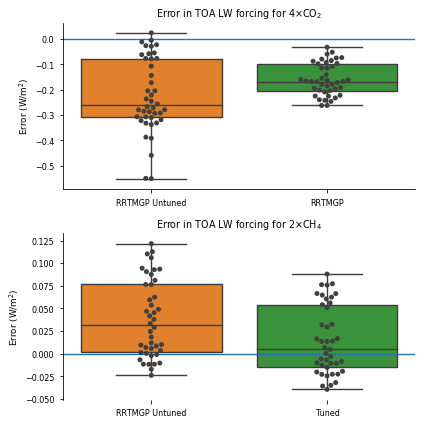

In [10]:
lbl = xr.open_mfdataset(lblfiles, concat_dim="forcing")
gpt = xr.open_mfdataset(gptfiles, concat_dim="forcing")
gpu = xr.open_mfdataset(gpufiles, concat_dim="forcing")
#
# Forcing calculations for flux up @ TOA: subtract pre-industrial
#
toa = lbl.isel(col=0,forcing=0).p_lev.argmin().values
forcing_lbl = lbl.flux_up.sel(forcing=slice(1, None)).isel(lev=toa) - lbl.flux_up.isel(forcing=0,lev=toa)
forcing_gpt = gpt.flux_up.sel(forcing=slice(1, None)).isel(lev=toa) - gpt.flux_up.isel(forcing=0,lev=toa)
forcing_gpu = gpu.flux_up.sel(forcing=slice(1, None)).isel(lev=toa) - gpu.flux_up.isel(forcing=0,lev=toa)

fig = plt.figure(figsize=(6,6))

axes = fig.add_subplot(211)
plot_err_distribution(axes, [(forcing_gpu-forcing_lbl).sel(forcing=0), (forcing_gpt-forcing_lbl).sel(forcing=0)], ["RRTMGP Untuned", "RRTMGP"], 
                      ylabel = "Error (W/m$^2$)", colors = [1,2])
axes.title.set_text("Error in TOA LW forcing for 4$\\times$CO$_2$")
sb.despine()
axes.spines["bottom"].set_visible(False)


axes = fig.add_subplot(212)
plot_err_distribution(axes, [(forcing_gpu-forcing_lbl).sel(forcing=1), (forcing_gpt-forcing_lbl).sel(forcing=1)], ["RRTMGP Untuned", "Tuned"], 
                      ylabel = "Error (W/m$^2$)", colors = [1,2])
axes.title.set_text("Error in TOA LW forcing for 2$\\times$CH$_4$")
sb.despine()
axes.spines["bottom"].set_visible(False)
plt.tight_layout()

plt.savefig("lw-toa-error-forcing.pdf", dpi=600)
lbl.close()
gpt.close()
gpu.close()

# Total flux errors

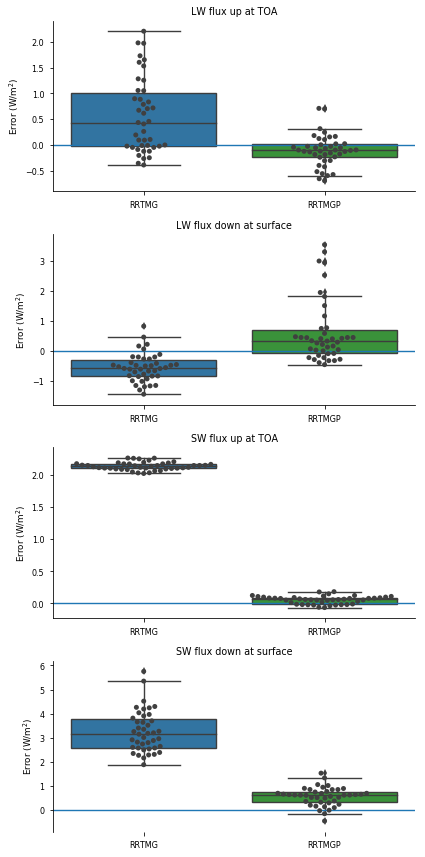

In [11]:
fig = plt.figure(figsize=(6,12))

#
# Longwave
#
axes = fig.add_subplot(411)
plot_single_level_errs(fig, axes, "toa", "flux_up", lw_lblrtm_file, \
                      [lw_rrtmg_file, lw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP"], colors = [0,2])
sb.despine()
axes.spines["bottom"].set_visible(False)
axes.title.set_text("LW flux up at TOA")

axes = fig.add_subplot(412)
plot_single_level_errs(fig, axes, "sfc", "flux_dn", lw_lblrtm_file, \
                      [lw_rrtmg_file, lw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP"], colors = [0,2])
sb.despine()
axes.spines["bottom"].set_visible(False)
axes.title.set_text("LW flux down at surface")

#
# Shortwave
#

axes = fig.add_subplot(413)
plot_single_level_errs(fig, axes, "toa", "flux_up", sw_charts_file, \
                      [sw_rrtmg_file, sw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP"], colors = [0,2])
sb.despine()
axes.spines["bottom"].set_visible(False)
axes.title.set_text("SW flux up at TOA")

axes = fig.add_subplot(414)
plot_single_level_errs(fig, axes, "sfc", "flux_dn", sw_charts_file, \
                      [sw_rrtmg_file, sw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP"], colors = [0,2])
sb.despine()
axes.spines["bottom"].set_visible(False)
axes.title.set_text("SW flux down at surface")

plt.tight_layout()
plt.savefig("total-error.pdf", dpi=600)

# Heating rates

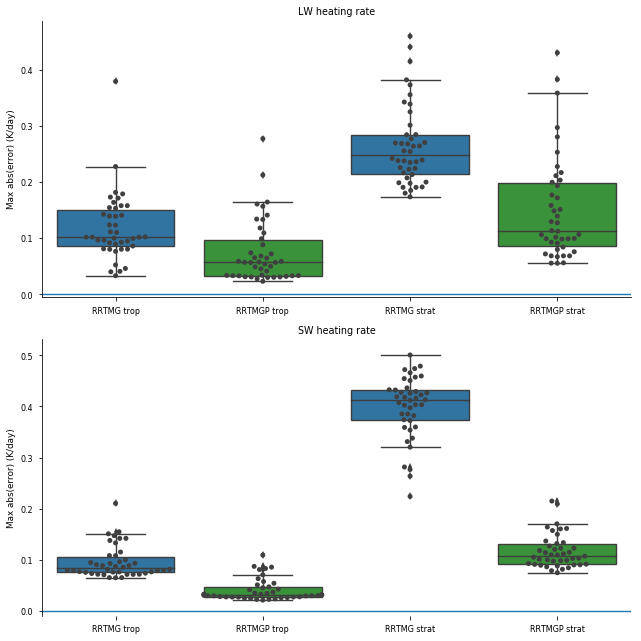

In [12]:
def plot_max_vert_err_distribution(axes, quantity, ref_file, test_files, test_labels, factor=1., yaxisunits="$\mathregular{W/m^2}", colors = None):
    ref_ds = xr.open_dataset(ref_file)
    tst_ds = [xr.open_dataset(f) for f in test_files]
    vaxis = "lay" if "lay" in ref_ds.variables[quantity].dims else "lev"
    
    toa = level_index('toa',   ref_ds, "p_" + vaxis).values
    sfc = level_index('sfc',   ref_ds, "p_" + vaxis).values
    trp = level_index('tropo', ref_ds, "p_" + vaxis).values
    if vaxis == 'lev':
        # Lower atmosphere - we are assuming arrays are ordered from bottom to top in using slice() 
        errs =                       [xr.ufuncs.fabs((tf - ref_ds).variables[quantity].isel(lev=slice(sfc,trp-1))).max(dim=vaxis)*factor for tf in tst_ds]
        # Upper atmosphere - neglect top layer/level
        # If we use a list comprehension here the last element is a "generator object" and not the data we want
        for tf in tst_ds: errs.append(xr.ufuncs.fabs((tf - ref_ds).variables[quantity].isel(lev=slice(trp,toa-1))).max(dim=vaxis)*factor)
    else:
        # Lower atmosphere - we are assuming arrays are ordered from bottom to top in using slice() 
        errs =                       [xr.ufuncs.fabs((tf - ref_ds).variables[quantity].isel(lay=slice(sfc,trp-1))).max(dim=vaxis)*factor for tf in tst_ds]
        # Upper atmosphere - neglect top layer/level
        # If we use a list comprehension here the last element is a "generator object" and not the data we want
        for tf in tst_ds: errs.append(xr.ufuncs.fabs((tf - ref_ds).variables[quantity].isel(lay=slice(trp,toa-1))).max(dim=vaxis)*factor)

        
    labs = [t + " " + l for l in ["trop", "strat"] for t in test_labels]   
    plot_err_distribution(axes, errs, labs, ylabel = "Max abs(error) (" +  yaxisunits +")", colors = colors)

    [tf.close() for tf in tst_ds]
    ref_ds.close()
    
fig = plt.figure(figsize=(9,9)) 

axes = fig.add_subplot(211)
plot_max_vert_err_distribution(axes, "heating_rate", lw_lblrtm_file, \
                      [lw_rrtmg_file, lw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP"], factor=86400., yaxisunits="K/day", colors = [0, 2, 0, 2])
sb.despine()
axes.spines["bottom"].set_visible(False)
axes.title.set_text("LW heating rate")

axes = fig.add_subplot(212)
plot_max_vert_err_distribution(axes, "heating_rate", sw_charts_file, \
                      [sw_rrtmg_file,  sw_rrtmgp_default_file], \
                      ["RRTMG", "RRTMGP"], factor=86400., yaxisunits="K/day", colors = [0, 2, 0, 2])
sb.despine()
axes.spines["bottom"].set_visible(False)
axes.title.set_text("SW heating rate")

plt.tight_layout()
plt.savefig("error-hr.pdf", dpi=600)

# Run RRTMGP on the RFMIP-IRF example atmospheres

In [13]:
rfmip_dir = os.path.join(rte_rrtmgp_dir, "examples", "rfmip-clear-sky")
copy2(os.path.join(rfmip_dir, "stage_files.py"), ".")

#
# Download and/or create input files and output template files 
#
subprocess.run(["python", "stage_files.py"])

CompletedProcess(args=['python', 'stage_files.py'], returncode=0)

In [14]:
#
# Build and run the RFMIP example programs that computes fluxes from netCDF Garand atmosphere files
#   This also requires having a valid Makefile.conf in the rte_rrtmgp_dir/build directory
# 
subprocess.run(["export RRTMGP_ROOT=" + rte_rrtmgp_dir + "; " + \
                "cd " + rfmip_dir + "; make "], shell=True)
rfmip_lw_exe_name = "rrtmgp_rfmip_lw"
rfmip_sw_exe_name = "rrtmgp_rfmip_sw"
conds_file        = "multiple_input4MIPs_radiation_RFMIP_UColorado-RFMIP-1-2_none.nc"

# arguments are block size, input conditions, coefficient files, forcing index, physics index
subprocess.run([os.path.join(rfmip_dir, rfmip_lw_exe_name), "8", conds_file, "data/coefficients_lw.nc"]) 
subprocess.run([os.path.join(rfmip_dir, rfmip_sw_exe_name), "8", conds_file, "data/coefficients_sw.nc"])

CompletedProcess(args=['/Users/robert/Codes/rte-rrtmgp/examples/rfmip-clear-sky/rrtmgp_rfmip_sw', '8', 'multiple_input4MIPs_radiation_RFMIP_UColorado-RFMIP-1-2_none.nc', 'data/coefficients_sw.nc'], returncode=0)

# Comparison of RRTMGP to reference calculations for RFMIP

In [15]:
#
# Access the data - new is RRTMGP, ref is LBLRTM/CHARTS
#
new = xr.open_mfdataset('*Efx*.nc')
ref = xr.open_mfdataset(os.path.join('data/rfmip/LBLRTM', 'r??.nc'))
new.load()
ref.load()

conds = xr.open_dataset(conds_file)
toa = conds.isel(site=0,expt=0).pres_level.argmin()
sfc = conds.isel(site=0,expt=0).pres_level.argmax()
conds.close()

# String formatting template
templ = '{} {:.3f} ({:.3f})'

In [16]:
#
# Manuscript Table 1: 
# RFMIP results: Error (and forcing) relative to PI
#
# Forcing - Present-day minus pre-industrial (see conds.expt_label)
#
ref_f = ref.isel(expt=0) - ref.isel(expt=1)
new_f = new.isel(expt=0) - new.isel(expt=1)

print("Forcing relative to PI: error, reference value")

# Someone more Pythonic than I would turn these results into a data frame. 
ref_f_avg = (ref_f * ref.profile_weight).sum(dim='site')
new_f_avg = (new_f * new.profile_weight).sum(dim='site')

#
# Up at top of atmosphere
#
print("Up at TOA")
print(templ.format("Longwave", \
                   (new_f_avg - ref_f_avg).isel(level=toa).rlu.values, \
                                ref_f_avg.isel(level=toa).rlu.values))
print(templ.format("Shortwave", \
                   (new_f_avg - ref_f_avg).isel(level=toa).rsu.values, 
                                ref_f_avg.isel(level=toa).rsu.values))

#
# Net absorption: Down minus up, toa minus surface
#
ref_f_avg_rln =  ref_f_avg.rld - ref_f_avg.rlu
new_f_avg_rln =  new_f_avg.rld - new_f_avg.rlu
ref_f_avg_rsn =  ref_f_avg.rsd - ref_f_avg.rsu
new_f_avg_rsn =  new_f_avg.rsd - new_f_avg.rsu
print("Net absorption")
print(templ.format("Longwave", \
      (new_f_avg_rln.isel(level=toa) - new_f_avg_rln.sel(level=sfc)).values - \
      (ref_f_avg_rln.isel(level=toa) - ref_f_avg_rln.sel(level=sfc)).values, \
      (ref_f_avg_rln.isel(level=toa) - ref_f_avg_rln.sel(level=sfc)).values))
print(templ.format("Shortwave", \
      (new_f_avg_rsn.isel(level=toa) - new_f_avg_rsn.sel(level=sfc)).values - \
      (ref_f_avg_rsn.isel(level=toa) - ref_f_avg_rsn.sel(level=sfc)).values, \
      (ref_f_avg_rsn.isel(level=toa) - ref_f_avg_rsn.sel(level=sfc)).values))

#
# Down at surface 
#
print("Down at surface")
print(templ.format("Longwave", \
                   (new_f_avg - ref_f_avg).isel(level=sfc).rld.values, \
                                ref_f_avg.isel(level=sfc).rld.values))
print(templ.format("Shortwave", \
                   (new_f_avg - ref_f_avg).isel(level=sfc).rsd.values, 
                                ref_f_avg.isel(level=sfc).rsd.values))

Forcing relative to PI: error, reference value
Up at TOA
Longwave 0.148 (-2.845)
Shortwave 0.007 (-0.058)
Net absorption
Longwave -0.055 (0.803)
Shortwave -0.051 (0.522)
Down at surface
Longwave -0.095 (2.083)
Shortwave 0.065 (-0.534)


In [17]:
#
# Manuscript Table 1: 
# RFMIP results: Error (and forcing) at present-day (see conds.expt_label)
#
print("Value at PD: error, reference value")

# For whatever reason xarray is unhappy computing the present-day weighted averages... 
# ref_pd_avg = (ref.isel(expt=0)  * ref.profile_weight).sum(dim='site')
# new_pd_avg = (new.isel(expt=0) * new.profile_weight).sum(dim='site')

#
# Up at top of atmosphere
#
print("Up at TOA")
print(templ.format("Longwave",  \
                  ((new.rlu.isel(expt=0) * ref.profile_weight) - \
                   (ref.rlu.isel(expt=0) * ref.profile_weight)).isel(level=toa).sum(dim='site').values, \
                   (ref.rlu.isel(expt=0) * ref.profile_weight).isel(level=toa).sum(dim='site').values))
print(templ.format("Shortwave",  \
                  ((new.rsu.isel(expt=0) * ref.profile_weight) - \
                   (ref.rsu.isel(expt=0) * ref.profile_weight)).isel(level=toa).sum(dim='site').values, \
                   (ref.rsu.isel(expt=0) * ref.profile_weight).isel(level=toa).sum(dim='site').values))

#
# Net absorption: Down minus up, toa minus surface
#
ref_avg_rln = ((ref.rld - ref.rlu) * ref.profile_weight).isel(expt=0).sum(dim='site')
ref_avg_rsn = ((ref.rsd - ref.rsu) * ref.profile_weight).isel(expt=0).sum(dim='site')
new_avg_rln = ((new.rld - new.rlu) * new.profile_weight).isel(expt=0).sum(dim='site')
new_avg_rsn = ((new.rsd - new.rsu) * new.profile_weight).isel(expt=0).sum(dim='site')


print("Net absorption")
print(templ.format("Longwave", \
      (new_avg_rln.isel(level=toa) - new_avg_rln.sel(level=sfc)).values - \
      (ref_avg_rln.isel(level=toa) - ref_avg_rln.sel(level=sfc)).values, \
      (ref_avg_rln.isel(level=toa) - ref_avg_rln.sel(level=sfc)).values))
print(templ.format("Shortwave", \
      (new_avg_rsn.isel(level=toa) - new_avg_rsn.sel(level=sfc)).values - \
      (ref_avg_rsn.isel(level=toa) - ref_avg_rsn.sel(level=sfc)).values, \
      (ref_avg_rsn.isel(level=toa) - ref_avg_rsn.sel(level=sfc)).values))

#
# Down at surface 
#
print("Down at surface")
print(templ.format("Longwave",  \
                  ((new.rld.isel(expt=0) * ref.profile_weight) - \
                   (ref.rld.isel(expt=0) * ref.profile_weight)).isel(level=sfc).sum(dim='site').values, \
                   (ref.rld.isel(expt=0) * ref.profile_weight).isel(level=sfc).sum(dim='site').values))
print(templ.format("Shortwave",  \
                  ((new.rsd.isel(expt=0) * ref.profile_weight) - \
                   (ref.rsd.isel(expt=0) * ref.profile_weight)).isel(level=sfc).sum(dim='site').values, \
                   (ref.rsd.isel(expt=0) * ref.profile_weight).isel(level=sfc).sum(dim='site').values))

Value at PD: error, reference value
Up at TOA
Longwave 0.033 (263.197)
Shortwave 0.165 (47.315)
Net absorption
Longwave -0.749 (-180.696)
Shortwave -0.610 (72.344)
Down at surface
Longwave 0.725 (315.346)
Shortwave -0.026 (245.553)


In [18]:
new.close()
ref.close()